In [1]:
# 필수 라이브러리 임포트
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.metrics import (classification_report, confusion_matrix, 
                           roc_auc_score, roc_curve, precision_recall_curve,
                           accuracy_score, precision_score, recall_score, f1_score)
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from imblearn.combine import SMOTEENN
from imblearn.over_sampling import SMOTE
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, callbacks, regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from sklearn.inspection import permutation_importance
import warnings
warnings.filterwarnings('ignore')

# 시각화 설정
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['figure.figsize'] = (12, 8)

print("=== 당뇨병 예측 데이터 분석 파이프라인 ===")
print("필요한 라이브러리가 성공적으로 로드되었습니다.")


=== 당뇨병 예측 데이터 분석 파이프라인 ===
필요한 라이브러리가 성공적으로 로드되었습니다.


In [2]:
df = pd.read_csv("../data/diabetes_prediction_dataset.csv")

✅ 결측치 개수:
 gender                 0
age                    0
hypertension           0
heart_disease          0
smoking_history        0
bmi                    0
HbA1c_level            0
blood_glucose_level    0
diabetes               0
dtype: int64

특성 개수: 8
샘플 개수: 100000
타겟 클래스 분포:
diabetes
0    91500
1     8500
Name: count, dtype: int64

데이터 분할 수행 중...
훈련 데이터 크기: (80000, 8)
테스트 데이터 크기: (20000, 8)
✅ age: 클리핑 범위 = [-30.00, 114.00]
✅ bmi: 클리핑 범위 = [14.75, 38.43]
✅ HbA1c_level: 클리핑 범위 = [2.70, 8.30]
✅ blood_glucose_level: 클리핑 범위 = [11.50, 247.50]

✅ 훈련 데이터 이상치 처리 후 통계 요약:
                age           bmi   HbA1c_level  blood_glucose_level
count  80000.000000  80000.000000  80000.000000         80000.000000
mean      41.900601     26.982955      5.519634           137.415075
std       22.529903      5.663003      1.047713            38.478979
min        0.080000     14.750000      3.500000            80.000000
25%       24.000000     23.630000      4.800000           100.000000
50%      

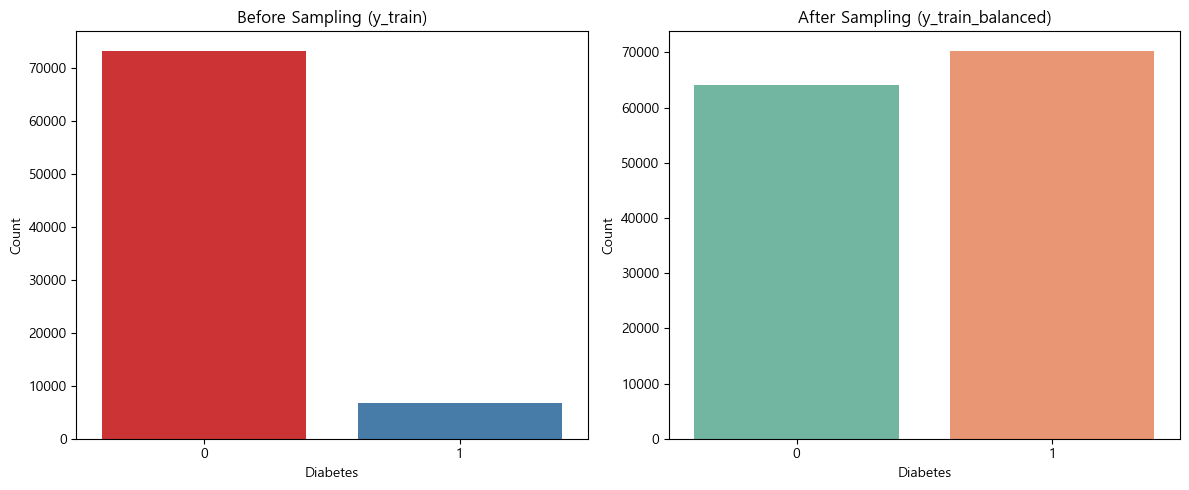

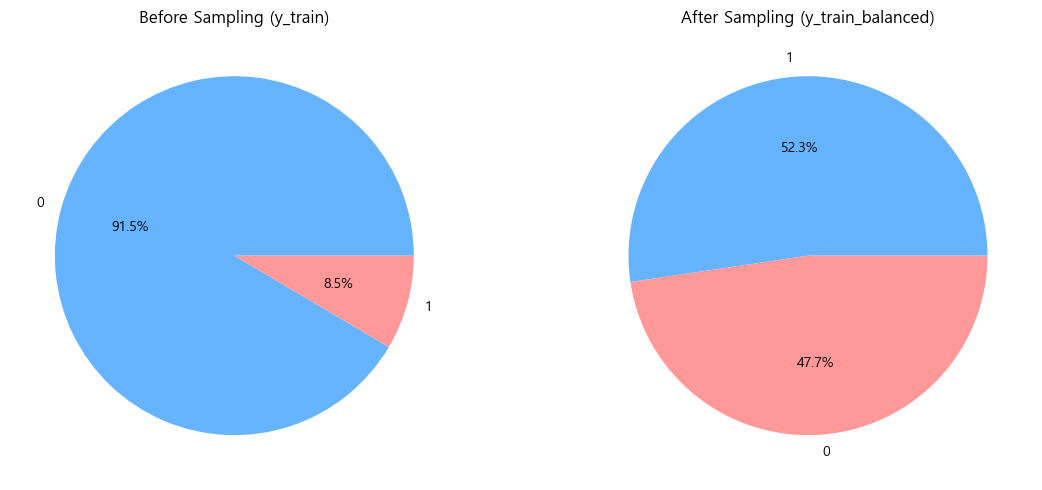


Robust 스케일링 적용 중...
전처리 완료!


In [3]:
# --- 기존 코드 유지 ---
# 1. 결측치 확인
print("✅ 결측치 개수:\n", df.isnull().sum())

# 2. 범주형 변수 매핑
gender_map = {'Female': 0, 'Male': 1, 'Other': 2}
smoking_map = {
    'never': 0, 'No Info': 1, 'former': 2,
    'not current': 3, 'current': 4, 'ever': 5
}
df['gender'] = df['gender'].map(gender_map)
df['smoking_history'] = df['smoking_history'].map(smoking_map)

# 3. 특성과 타겟 분리
X = df.drop('diabetes', axis=1)
y = df['diabetes']

print(f"\n특성 개수: {X.shape[1]}")
print(f"샘플 개수: {X.shape[0]}")
print(f"타겟 클래스 분포:\n{y.value_counts()}")

# 4. 데이터 분할
print("\n데이터 분할 수행 중...")
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print(f"훈련 데이터 크기: {X_train.shape}")
print(f"테스트 데이터 크기: {X_test.shape}")

# 5. 이상치 처리 (훈련 데이터에만 적용)
def clip_outliers_iqr(df, cols):
    for col in cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df[col] = np.clip(df[col], lower_bound, upper_bound)
        print(f"✅ {col}: 클리핑 범위 = [{lower_bound:.2f}, {upper_bound:.2f}]")
    return df

numeric_cols = ['age', 'bmi', 'HbA1c_level', 'blood_glucose_level']
X_train = clip_outliers_iqr(X_train, numeric_cols)

# 6. 클리핑 후 통계 확인 (훈련 데이터만 확인)
print("\n✅ 훈련 데이터 이상치 처리 후 통계 요약:")
print(X_train[numeric_cols].describe())

# --- 이후 기존과 동일 ---
# 7. 샘플링
print("\nSMOTEENN 하이브리드 샘플링 적용 중...")
sampler = SMOTEENN(random_state=42)
X_train_balanced, y_train_balanced = sampler.fit_resample(X_train, y_train)

print(f"균형화된 훈련 데이터 크기: {X_train_balanced.shape}")
print(f"균형화된 클래스 분포:\n{pd.Series(y_train_balanced).value_counts()}")


import matplotlib.pyplot as plt
import seaborn as sns

# 8. 샘플링 전후 클래스 분포 시각화 (countplot)
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.countplot(x=y_train, ax=axes[0], palette='Set1')
axes[0].set_title("Before Sampling (y_train)")
axes[0].set_xlabel("Diabetes")
axes[0].set_ylabel("Count")

sns.countplot(x=y_train_balanced, ax=axes[1], palette='Set2')
axes[1].set_title("After Sampling (y_train_balanced)")
axes[1].set_xlabel("Diabetes")
axes[1].set_ylabel("Count")

plt.tight_layout()
plt.show()

# 9. 샘플링 전후 클래스 분포 시각화 (pie chart)
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# 10. 비율 계산
y_train_counts = y_train.value_counts()
y_train_balanced_counts = pd.Series(y_train_balanced).value_counts()

axes[0].pie(
    y_train_counts, labels=y_train_counts.index,
    autopct='%1.1f%%', colors=['#66b3ff', '#ff9999']
)
axes[0].set_title("Before Sampling (y_train)")

axes[1].pie(
    y_train_balanced_counts, labels=y_train_balanced_counts.index,
    autopct='%1.1f%%', colors=['#66b3ff', '#ff9999']
)
axes[1].set_title("After Sampling (y_train_balanced)")

plt.tight_layout()
plt.show()

# 11. 스케일링
print("\nRobust 스케일링 적용 중...")
scaler = RobustScaler()
numeric_features = ['age', 'bmi', 'HbA1c_level', 'blood_glucose_level']

X_train_balanced_scaled = X_train_balanced.copy()
X_train_balanced_scaled[numeric_features] = scaler.fit_transform(X_train_balanced[numeric_features])

X_test_scaled = X_test.copy()
X_test_scaled[numeric_features] = scaler.transform(X_test[numeric_features])

print("전처리 완료!")



=== 4. 상관관계 분석 ===


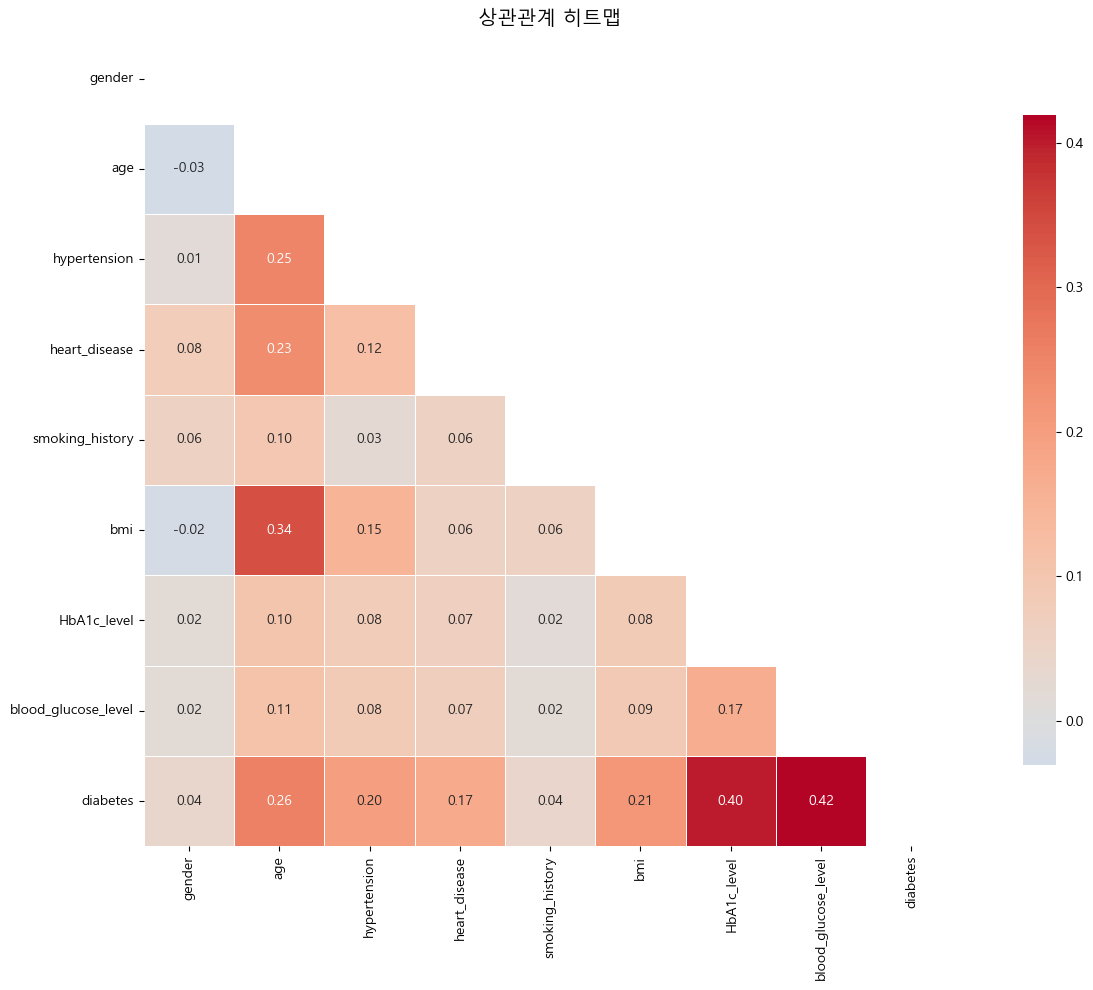


당뇨병과의 상관관계 (절댓값 기준, 상위 10개):
diabetes               1.000000
blood_glucose_level    0.419558
HbA1c_level            0.400660
age                    0.258008
bmi                    0.214357
hypertension           0.197823
heart_disease          0.171727
smoking_history        0.042710
gender                 0.037411
Name: diabetes, dtype: float64


In [4]:
# 상관관계 분석
print("\n=== 4. 상관관계 분석 ===")

# 상관관계 히트맵
plt.figure(figsize=(14, 10))
# 숫자형 데이터만 선택
numeric_df = df.select_dtypes(include=[np.number])
corr = numeric_df.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask=mask, annot=True, fmt=".2f", cmap='coolwarm', 
            center=0, square=True, linewidths=.5, cbar_kws={"shrink": .8})
plt.title('상관관계 히트맵', fontsize=14)
plt.tight_layout()
plt.show()

# 당뇨병과 상관관계가 높은 변수들
diabetes_corr = corr['diabetes'].abs().sort_values(ascending=False)
print("\n당뇨병과의 상관관계 (절댓값 기준, 상위 10개):")
print(diabetes_corr.head(10))


In [1]:
# 필요한 라이브러리 임포트
import os
import pickle
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.metrics import (roc_curve, auc, precision_recall_curve, 
                           classification_report, confusion_matrix,
                           precision_score, recall_score, f1_score, accuracy_score)
from sklearn.ensemble import (RandomForestClassifier, GradientBoostingClassifier, 
                            VotingClassifier, StackingClassifier)
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.calibration import CalibratedClassifierCV
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping

# 모델 저장 경로
model_dir = './saved_models'
os.makedirs(model_dir, exist_ok=True)

# 머신러닝 모델 정의
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'SVM': SVC(probability=True, random_state=42),
    'KNN': KNeighborsClassifier(n_neighbors=5),
    'Voting(Soft)': VotingClassifier(
        estimators=[
            ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
            ('gb', GradientBoostingClassifier(random_state=42)),
            ('svm', SVC(probability=True, random_state=42))
        ], 
        voting='soft'
    ),
    'Stacking': StackingClassifier(
        estimators=[
            ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
            ('gb', GradientBoostingClassifier(random_state=42))
        ], 
        final_estimator=LogisticRegression()
    )
}

# 결과 저장 딕셔너리
model_results = {}
trained_models = {}

# 머신러닝 모델 학습 및 저장/불러오기
for name, model in models.items():
    try:
        model_path = os.path.join(model_dir, f'{name.replace(" ", "_")}.joblib')
        
        if os.path.exists(model_path):
            print(f"\n{name} 모델 불러오는 중...")
            model = joblib.load(model_path)
        else:
            print(f"\n{name} 모델 학습 중...")
            if name in ['Voting(Soft)', 'Stacking']:
                model = CalibratedClassifierCV(model, method='isotonic')
            model.fit(X_train_balanced_scaled, y_train_balanced)
            joblib.dump(model, model_path)
        
        trained_models[name] = model

        y_pred = model.predict(X_test_scaled)
        y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]

        model_results[name] = {
            'fpr': roc_curve(y_test, y_pred_proba)[0],
            'tpr': roc_curve(y_test, y_pred_proba)[1],
            'auc': auc(roc_curve(y_test, y_pred_proba)[0], roc_curve(y_test, y_pred_proba)[1]),
            'precision': precision_score(y_test, y_pred),
            'recall': recall_score(y_test, y_pred),
            'f1': f1_score(y_test, y_pred),
            'accuracy': accuracy_score(y_test, y_pred),
            'y_pred_proba': y_pred_proba
        }
        
    except Exception as e:
        print(f"{name} 모델 처리 실패: {str(e)}")

# DNN 모델 정의
def build_dnn():
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(128, activation='relu', input_shape=(X_train_balanced_scaled.shape[1],)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Deep MLP 모델 정의
def build_deep_mlp():
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(256, activation='relu', input_shape=(X_train_balanced_scaled.shape[1],)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# DNN 기본 모델
dnn_model_path = os.path.join(model_dir, 'DNN_model.keras')
if os.path.exists(dnn_model_path):
    print("\nDNN 모델 불러오는 중...")
    dnn = tf.keras.models.load_model(dnn_model_path)
else:
    print("\nDNN 모델 학습 중...")
    dnn = build_dnn()
    dnn.fit(X_train_balanced_scaled, y_train_balanced, epochs=50, validation_split=0.2, verbose=0)
    dnn.save(dnn_model_path)

dnn_pred_proba = dnn.predict(X_test_scaled).ravel()
model_results['DNN'] = {
    'fpr': roc_curve(y_test, dnn_pred_proba)[0],
    'tpr': roc_curve(y_test, dnn_pred_proba)[1],
    'auc': auc(roc_curve(y_test, dnn_pred_proba)[0], roc_curve(y_test, dnn_pred_proba)[1]),
    'precision': precision_score(y_test, (dnn_pred_proba > 0.5).astype(int)),
    'recall': recall_score(y_test, (dnn_pred_proba > 0.5).astype(int)),
    'f1': f1_score(y_test, (dnn_pred_proba > 0.5).astype(int)),
    'accuracy': accuracy_score(y_test, (dnn_pred_proba > 0.5).astype(int)),
    'y_pred_proba': dnn_pred_proba
}

# DNN EarlyStopping 모델
dnn_early_model_path = os.path.join(model_dir, 'DNN_EarlyStopping.keras')
if os.path.exists(dnn_early_model_path):
    print("\nDNN EarlyStopping 모델 불러오는 중...")
    dnn_early = tf.keras.models.load_model(dnn_early_model_path)
else:
    print("\nDNN EarlyStopping 모델 학습 중...")
    dnn_early = build_dnn()
    early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    dnn_early.fit(X_train_balanced_scaled, y_train_balanced, epochs=100, validation_split=0.2,
                  callbacks=[early_stop], verbose=0)
    dnn_early.save(dnn_early_model_path)

dnn_early_pred_proba = dnn_early.predict(X_test_scaled).ravel()
model_results['DNN_EarlyStopping'] = {
    'fpr': roc_curve(y_test, dnn_early_pred_proba)[0],
    'tpr': roc_curve(y_test, dnn_early_pred_proba)[1],
    'auc': auc(roc_curve(y_test, dnn_early_pred_proba)[0], roc_curve(y_test, dnn_early_pred_proba)[1]),
    'precision': precision_score(y_test, (dnn_early_pred_proba > 0.5).astype(int)),
    'recall': recall_score(y_test, (dnn_early_pred_proba > 0.5).astype(int)),
    'f1': f1_score(y_test, (dnn_early_pred_proba > 0.5).astype(int)),
    'accuracy': accuracy_score(y_test, (dnn_early_pred_proba > 0.5).astype(int)),
    'y_pred_proba': dnn_early_pred_proba
}

# Deep MLP 모델
deep_mlp_model_path = os.path.join(model_dir, 'Deep_MLP.keras')
if os.path.exists(deep_mlp_model_path):
    print("\nDeep MLP 모델 불러오는 중...")
    deep_mlp = tf.keras.models.load_model(deep_mlp_model_path)
else:
    print("\nDeep MLP 모델 학습 중...")
    deep_mlp = build_deep_mlp()
    early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    deep_mlp.fit(X_train_balanced_scaled, y_train_balanced, epochs=100, validation_split=0.2,
                 callbacks=[early_stop], verbose=0)
    deep_mlp.save(deep_mlp_model_path)

deep_mlp_pred_proba = deep_mlp.predict(X_test_scaled).ravel()
model_results['Deep_MLP'] = {
    'fpr': roc_curve(y_test, deep_mlp_pred_proba)[0],
    'tpr': roc_curve(y_test, deep_mlp_pred_proba)[1],
    'auc': auc(roc_curve(y_test, deep_mlp_pred_proba)[0], roc_curve(y_test, deep_mlp_pred_proba)[1]),
    'precision': precision_score(y_test, (deep_mlp_pred_proba > 0.5).astype(int)),
    'recall': recall_score(y_test, (deep_mlp_pred_proba > 0.5).astype(int)),
    'f1': f1_score(y_test, (deep_mlp_pred_proba > 0.5).astype(int)),
    'accuracy': accuracy_score(y_test, (deep_mlp_pred_proba > 0.5).astype(int)),
    'y_pred_proba': deep_mlp_pred_proba
}



Logistic Regression 모델 불러오는 중...
Logistic Regression 모델 처리 실패: name 'X_test_scaled' is not defined

Random Forest 모델 불러오는 중...
Random Forest 모델 처리 실패: name 'X_test_scaled' is not defined

Gradient Boosting 모델 불러오는 중...
Gradient Boosting 모델 처리 실패: name 'X_test_scaled' is not defined

SVM 모델 학습 중...
SVM 모델 처리 실패: name 'X_train_balanced_scaled' is not defined

KNN 모델 학습 중...
KNN 모델 처리 실패: name 'X_train_balanced_scaled' is not defined

Voting(Soft) 모델 학습 중...
Voting(Soft) 모델 처리 실패: name 'X_train_balanced_scaled' is not defined

Stacking 모델 학습 중...
Stacking 모델 처리 실패: name 'X_train_balanced_scaled' is not defined

DNN 모델 학습 중...


NameError: name 'X_train_balanced_scaled' is not defined

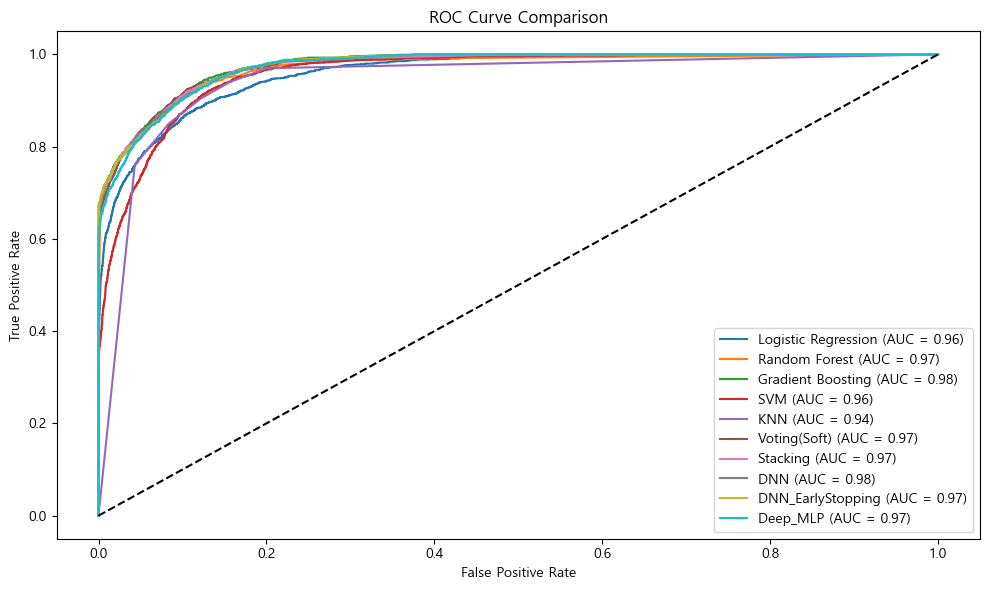

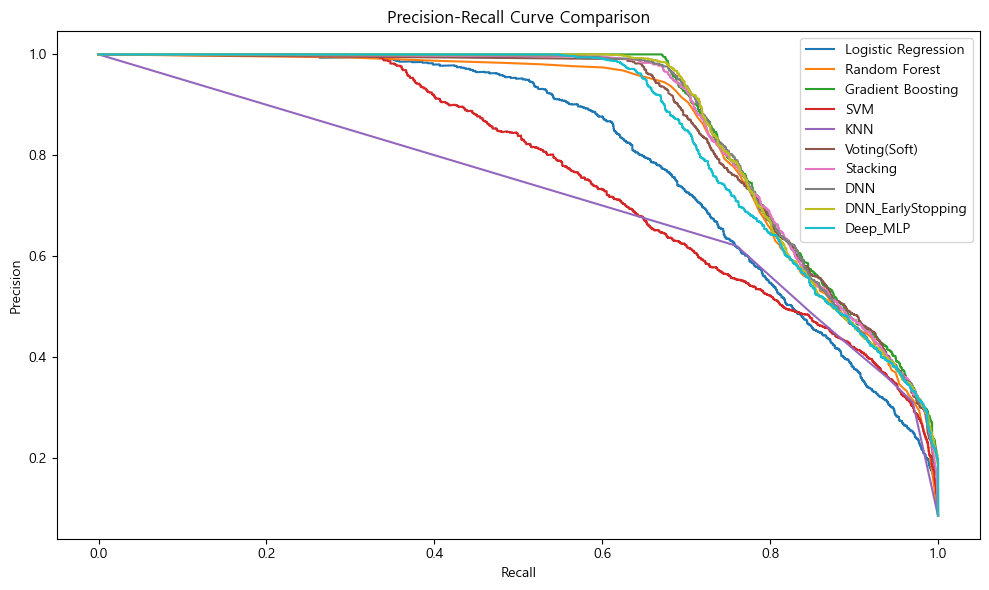

<Figure size 1200x600 with 0 Axes>

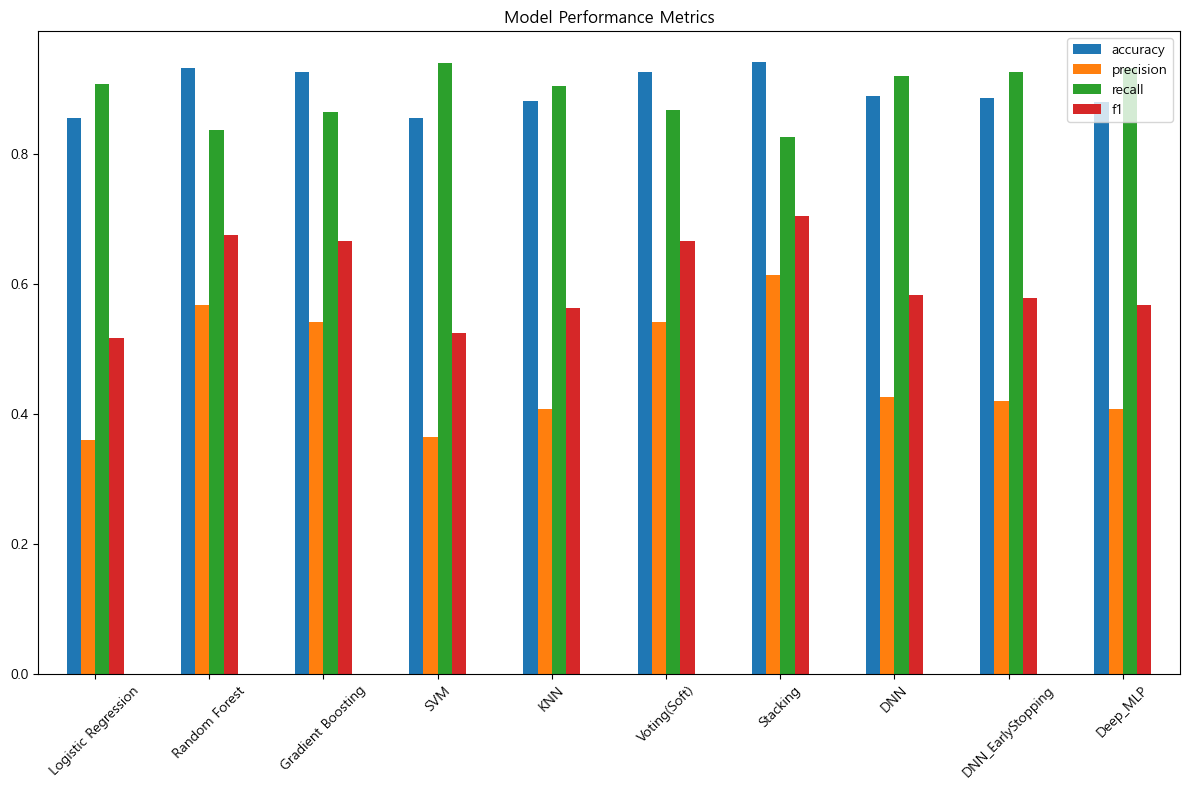

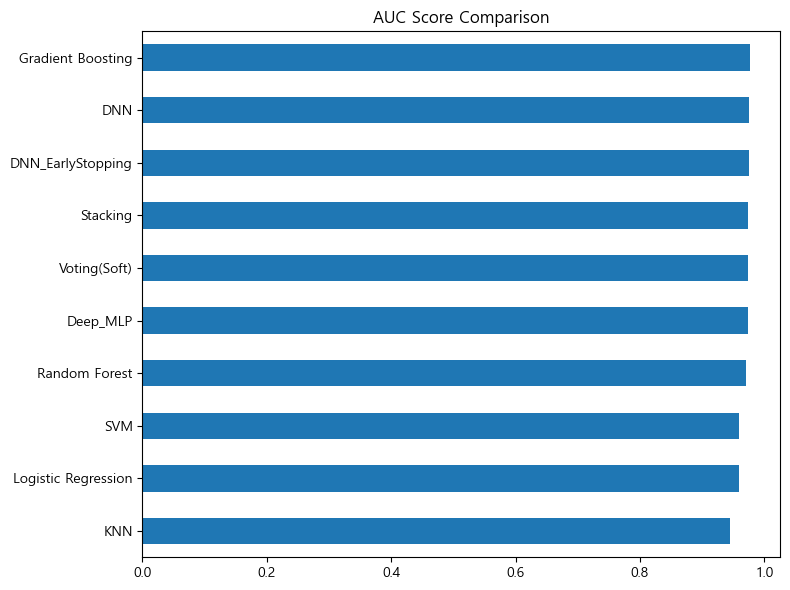

Gradient Boosting LIME 실패: KeyError - 0
DNN → LIME 생략
DNN_EarlyStopping → LIME 생략
Stacking LIME 실패: KeyError - 0
Voting(Soft) LIME 실패: KeyError - 0


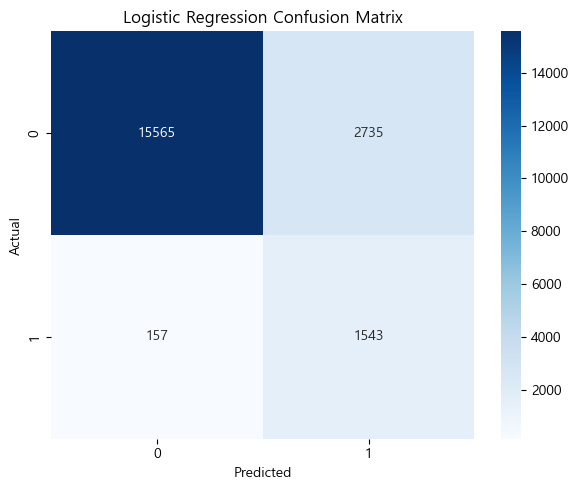

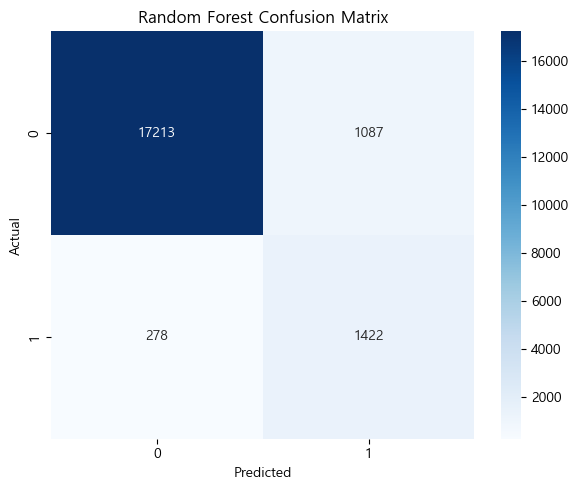

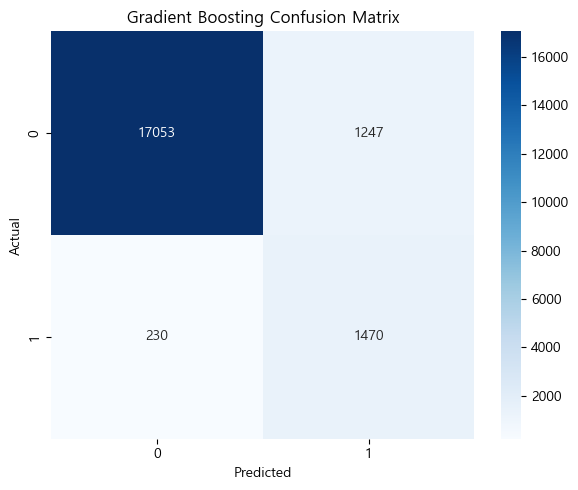

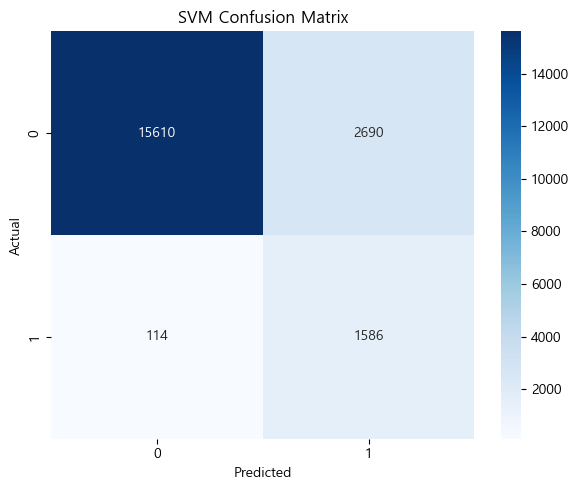

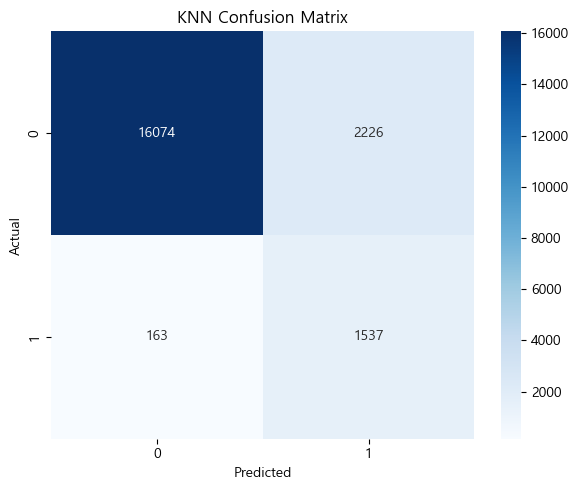

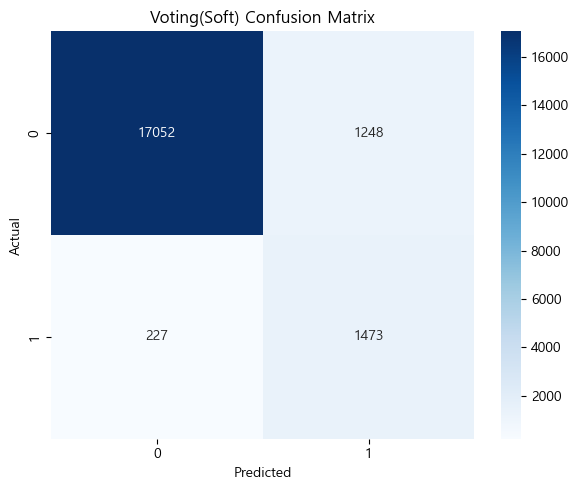

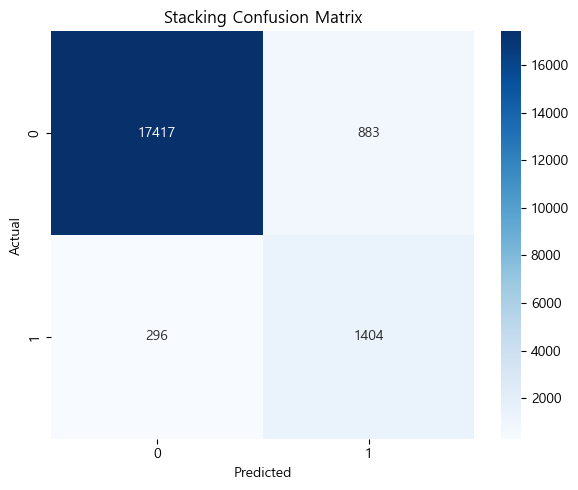

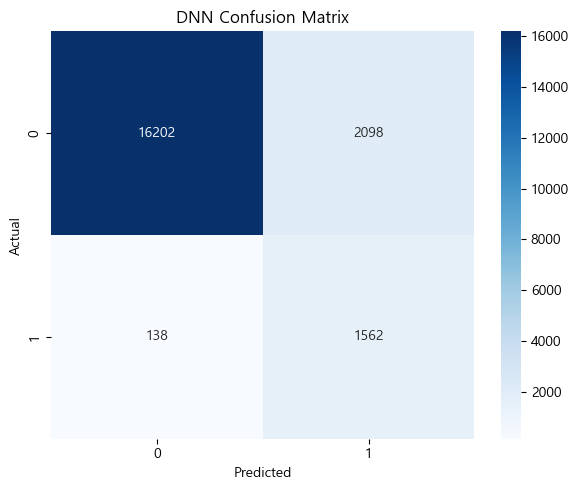

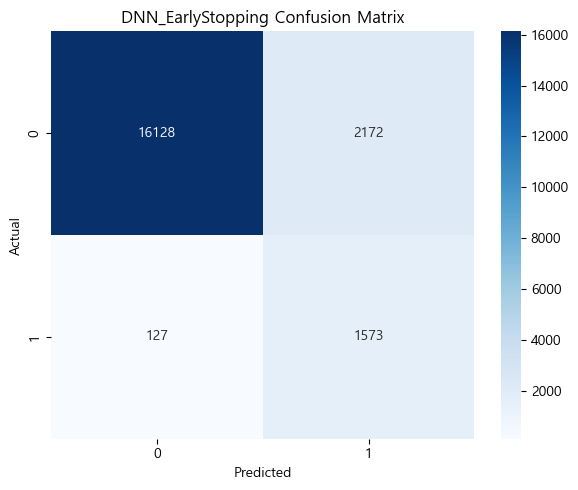

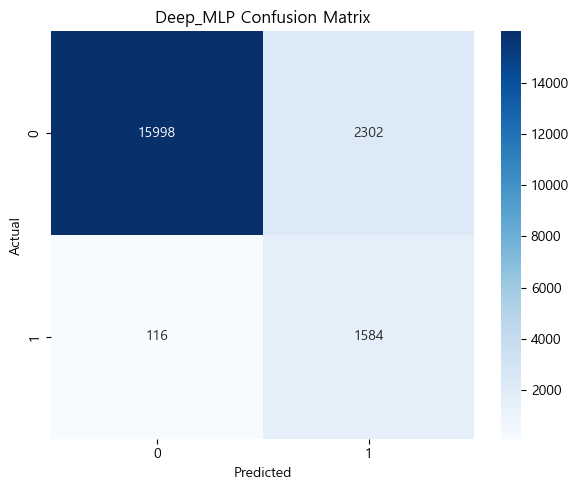

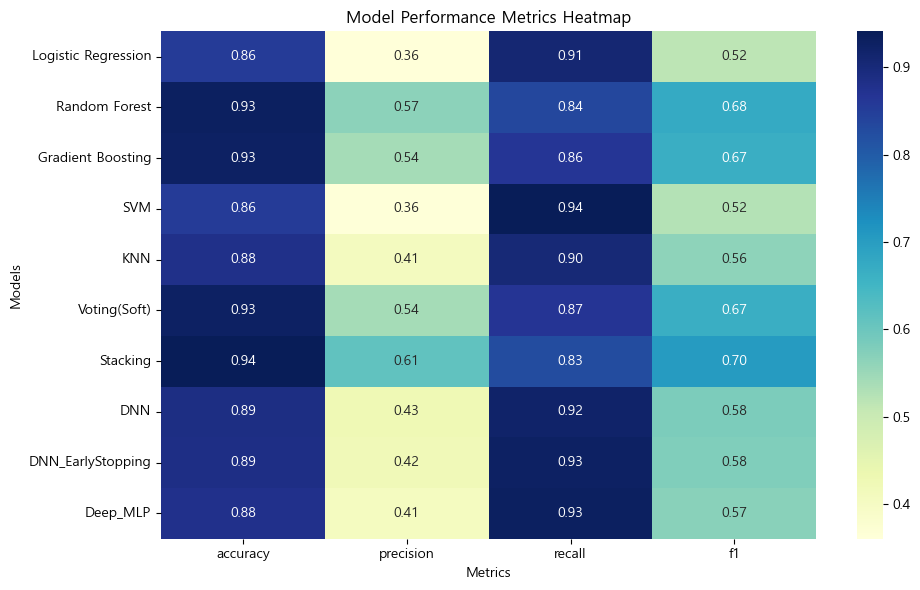

In [10]:
# ===========================
# 📊 시각화 전용 코드 (전문 수정 버전)
# ===========================

# 0️⃣ output_dir 생성
import os

# 모델 저장 경로와 별도로 결과 그래프 저장 경로 생성
output_dir = './output_plots'
os.makedirs(output_dir, exist_ok=True)

# 1️⃣ ROC Curve
plt.figure(figsize=(10, 6))
for name, result in model_results.items():
    plt.plot(result['fpr'], result['tpr'], label=f'{name} (AUC = {result["auc"]:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'roc_curve.png'))
plt.show()

# 2️⃣ Precision-Recall Curve
plt.figure(figsize=(10, 6))
for name, result in model_results.items():
    precision, recall, _ = precision_recall_curve(y_test, result['y_pred_proba'])
    plt.plot(recall, precision, label=name)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve Comparison')
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'precision_recall_curve.png'))
plt.show()

# 3️⃣ 성능 지표 막대 그래프
metrics_df = pd.DataFrame(model_results).T[['accuracy', 'precision', 'recall', 'f1']]
plt.figure(figsize=(12, 6))
metrics_df.plot(kind='bar', rot=45)
plt.title('Model Performance Metrics')
plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'performance_metrics.png'))
plt.show()

# 4️⃣ AUC 수평 막대 그래프
plt.figure(figsize=(8, 6))
pd.Series({k: v['auc'] for k, v in model_results.items()}).sort_values().plot(kind='barh')
plt.title('AUC Score Comparison')
plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'auc_comparison.png'))
plt.show()

# 5️⃣ LIME Feature Importance (상위 5개 AUC 모델만)
top_models = sorted(model_results.items(), key=lambda x: x[1]['auc'], reverse=True)[:5]

lime_count = 0
for name, _ in top_models:
    if name in ['DNN', 'DNN_EarlyStopping', 'Deep_MLP']:
        print(f"{name} → LIME 생략")
        continue
    
    try:
        exp = explainer.explain_instance(
            X_test_scaled[0],  # Scaled 데이터 사용
            trained_models[name].predict_proba,
            num_features=5
        )
        
        exp_map = exp.as_map()
        available_labels = list(exp_map.keys())

        if 1 in available_labels:
            target_label = 1
        elif 0 in available_labels:
            target_label = 0
        else:
            print(f"{name} LIME 실패: no valid label in exp.as_map()")
            continue  # skip this model

        features = [explainer.feature_names[idx] for idx, _ in exp_map[target_label]]
        values = [weight for _, weight in exp_map[target_label]]

        # Plot
        plt.figure(figsize=(8, 5))
        plt.barh(features, values, alpha=0.7)
        plt.title(f'{name} - LIME Feature Importance (label={target_label})')
        plt.tight_layout()
        plt.savefig(os.path.join(output_dir, f'{name.replace(" ", "_")}_LIME_feature_importance.png'))
        plt.show()

        print(f"{name} → LIME 완료 (label={target_label})")
        lime_count += 1

    except Exception as e:
        print(f"{name} LIME 실패: {type(e).__name__} - {e}")

# 6️⃣ 혼동 행렬들 (모든 모델 개별 저장)
# confusion_matrices 만들기
confusion_matrices = {}
for name, result in model_results.items():
    y_pred_label = (result['y_pred_proba'] > 0.5).astype(int)
    cm = confusion_matrix(y_test, y_pred_label)
    confusion_matrices[name] = cm

for name, cm in confusion_matrices.items():
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'{name} Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, f'{name.replace(" ", "_")}_confusion_matrix.png'))
    plt.show()

# 7️⃣ 모델별 성능 지표 Heatmap (표 형태)

# 모델 성능 데이터프레임 준비
metrics_df = pd.DataFrame(model_results).T[['accuracy', 'precision', 'recall', 'f1']].astype(float)

# Heatmap 그리기
plt.figure(figsize=(10, len(metrics_df) * 0.6))  # 모델 개수에 따라 height 자동 조절
sns.heatmap(metrics_df, annot=True, fmt='.2f', cmap='YlGnBu', cbar=True)

plt.title('Model Performance Metrics Heatmap')
plt.xlabel('Metrics')
plt.ylabel('Models')
plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'performance_metrics_heatmap.png'))
plt.show()
